<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/06-many-two-state-systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/06-many-two-state-systems.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 06 - Many two level systems

Last time, we added just one extra TLS and we got some surprising new physics - non-radiative excitation transfer. Excitations can move from one TLS to another without the emission and absorption processes that one would normally consider essential.

As you might imagine, there's more physics waiting to be found as we continue adding more TLS. We'll see the first hints of accelerated quantum processes in this notebook as we develop the computational strategies necessary to study many particle quantum systems. 

In [48]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *

from qutip.cy.piqs import j_min, j_vals, m_vals

from scipy.stats import linregress
from scipy.signal import find_peaks


# The helper file below brings functions created in previous tutorials and adds an extra one
# make_df_for_energy_scan - we made this in tutorial 4
# make_braket_labels - we made this in tutorial 4
# simulate - we made this in tutorial 4
# plot_prob - made from code used for plotting in tutorial 4
# prettify_states - nice way to display many QuTiP states for side by side comparison
# 
from libs.helper_06_tutorial import *

## Recap

Last time, we motivated that for many TLS, a helpful way to write the Hamiltonian is

$$H =  \Delta E J_{Nz} + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)2J_{Nx}$$

In [419]:
H_latex = "$H = \Delta E J_{Nz} + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )2J_{Nx}$ "

where:

- The [total angular momentum operators](https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf) ($J$) for $N$ TLS:

$$J_{Nx} = \overset{N}{\underset{n=1}{\Sigma}} S_{n x} \,\,\,\,\,\, J_{Ny} = \overset{N}{\underset{n=1}{\Sigma}} S_{n y} \,\,\,\,\,\, J_{Nz} = \overset{N}{\underset{n=1}{\Sigma}} S_{n z}$$

- The spin operators ($S$) for a [spin 1/2 particle](https://en.wikipedia.org/wiki/Spin-%C2%BD#Observables):

$$
S_x = \frac{1}{2}\sigma_x \,\,\,\,\,\, S_y = \frac{1}{2}\sigma_y \,\,\,\,\,\, S_z = \frac{1}{2}\sigma_z
$$



Previously we only looked at 2 TLS, but we can easily extend our "make_operators" function to create operators for an arbitrary number of TLS.

In [3]:
def make_operators(max_bosons, parity=0, num_TLS=1):
    
    a     = tensor([destroy(max_bosons+1)] + [qeye(2) for i in range(1,num_TLS+1)])      # tensorised boson destruction operator
    J     = jspin(num_TLS, basis="uncoupled")
    Jx    = tensor(qeye(max_bosons+1), J[0])                                             # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                                             # tensorised Jx operator
    J2    = tensor(qeye(max_bosons+1), J[0]*J[0] + J[1]*J[1] + J[2]*J[2])                # tensorised J^2 operator

    two_state     = Jz                                 # two state system energy operator   Jz
    bosons        = (a.dag()*a+0.5)                    # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                          # boson number operator              𝑎†𝑎
    interaction   = 2*(a.dag() + a) * Jx               # interaction energy operator        2(𝑎†+𝑎)Jz  
    
    P = (1j*np.pi*(number + Jz + num_TLS/2)).expm()               # parity operator 
    
    # map from QuTiP number states to |n,±, ±, ...> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n, *ms) for n in possible_ns for ms in product(possible_ms, repeat=num_TLS)]

    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
        
        two_state       = two_state.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction     = interaction.extract_states(p)
        J2              = J2.extract_states(p)  
        nm_list        = [nm_list[i] for i in p]
  
    
    return two_state, bosons, interaction, number, nm_list, J2

## Excitation transfer 

Let's jump straight into it and have a go at simulating excitation transfer when we have 2, 4, 8 and 10 TLS. (You can try 16 and see if your computer can handle it 😉)

For us to avoid energy transfer processes, in which excitations in the TLS can be exchanged with a number of bosons, we need to set the transition energy $\Delta E$ to a non integer multiple of the boson energy $\omega$:

In [113]:
DeltaE = 2.5
omega = 1

We'll keep the interaction strength the same as last time:

In [114]:
U = 0.01

We'll start the system off with 0 bosons and put the excitation in the first TLS. In other words:

- $|0,+,- \rangle$ for $N=2$
- $|0,+,-,-,- \rangle$ for $N=4$
- $|0,+,-,-,-,-, -,-,-  \rangle$ for $N=8$
- $|0,+,-,-,-,-, -,-,-,-,- \rangle$ for $N=10$



As we increase the number of TLS, it's going to be a pain to find which QuTiP number state corresponds to each of these states. That's because the number of possible states grows like $2^N$ 😱. Let's create a little function to help us out with creating $\Psi_0$:

In [115]:
def create_single_excitation_psi0(nm_list, num_bosons=0):
    num_TLS = len(nm_list[0])-1
    TLS_state = ["-",]*num_TLS  # Put all TLS in "-" state
    TLS_state[0] = "+" # Put the first TLS in the "+"
    ind = nm_list.index((num_bosons,) + tuple(TLS_state))  # Create combined boson+TLS state and find the number state QuTiP number state corresponding to it
    psi0 = basis(len(nm_list), ind) # Create the state
    return psi0, ind

Let's now run the simulations and plot the probability that the system remains in its initial state $\Psi_0$. We plot this instead of the probabilities of all the states because there are just too many states to plot.

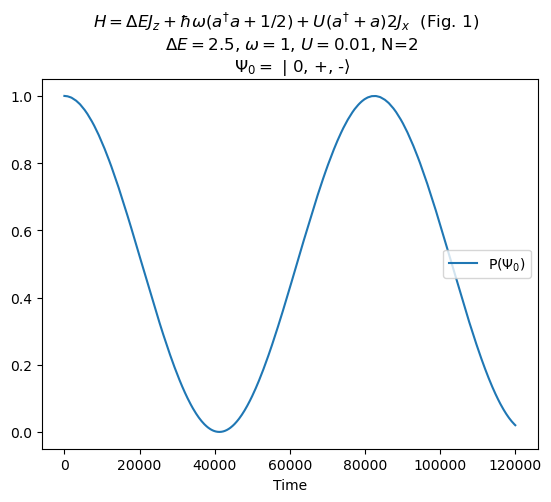

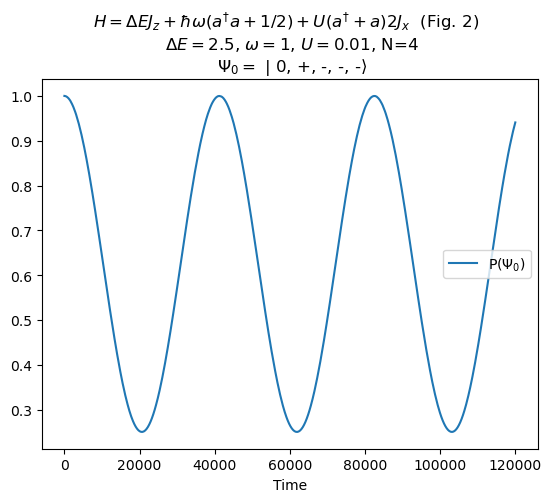

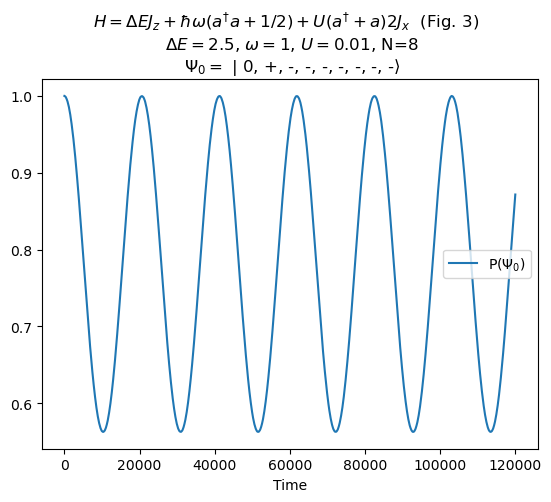

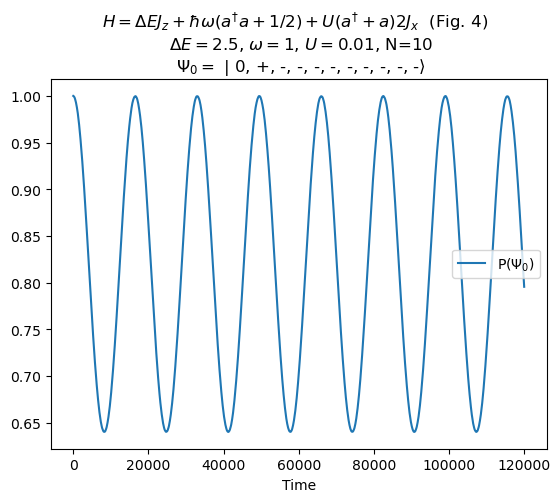

CPU times: user 2min 8s, sys: 4.9 s, total: 2min 12s
Wall time: 1min 47s


In [116]:
%%time 
# %%time must be at the top of the cell and by itself. It tells you the "Wall time" (how long the cell took to run) at the end of the output (should be about 2 min).

Ns = [2,4,8,10] # number of TLS we want to simulation
times = np.linspace(0.0, 120000.0, 1000) # simulation time
rabi = [] # For storing rabi frequency associated with excitation transfer

for i, N in enumerate(Ns):
    two_state, bosons, interaction, number, nm_list, J2 = make_operators(max_bosons=2, parity=-1, num_TLS=N)

    bra_labels, ket_labels = make_braket_labels(nm_list)
    
    H = DeltaE*two_state + omega*bosons + U*interaction

    psi0, psi0_ind = create_single_excitation_psi0(nm_list,0)

    # We are using custom simulate function from last tutorial. These are quicker than QuTips solvers for our specific purpose
    P, psi = simulate(H, psi0, times)

    # find_peaks from SciPy helps us find peaks. 
    # The first peak should give us the end of the first rabi cycle because P(psi_0) starts out a max of 1
    peaks, _ = find_peaks(P[psi0_ind], prominence=0.05)
    peak_times = times[peaks]
   
    rabi.append(2*np.pi / peak_times[0])

    plt.plot(times, P[psi0_ind], label="P($\Psi_0$)")
    plt.xlabel("Time")
    plt.legend(loc="right")
    plt.title(f"{H_latex} (Fig. {i+1})  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={N} \n $\Psi_0 =$ {ket_labels[psi0_ind]}")
    plt.show();

Fig 1 shows the same simulation results as Fig 11 from the last tutorial. Here we have complete excitation transfer from the first TLS into the second because the probability oscillates between 1 and 0. 

As we increase the number of TLS (Fig 2,3,4) we see:
1. the frequency of the transfer cycles increases
2. the amplitude of the transfer cycles decreases (we don't get "complete" oscillations between 1 and 0)

Let's see how the rabi frequency associated with the excitation transfer time scales with TLS number.

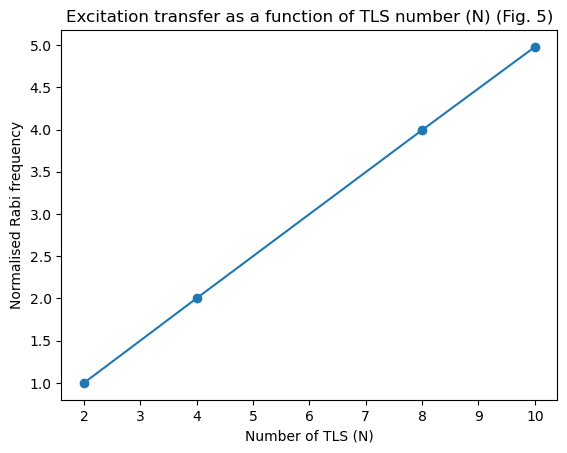

In [118]:
plt.plot(Ns,rabi/rabi[0],"-o")
plt.xlabel("Number of TLS (N)")
plt.ylabel("Normalised Rabi frequency");
plt.title("Excitation transfer as a function of TLS number (N) (Fig. 5)");

Although Fig. 5 suggests that excitation transfer is enhanced by a factor of $N$ as we add more TLS, the decreasing amplitude tells us that the transfer is not "complete". In other words, as we increase the number of TLS, the excitation is most likely to remain in the first TLS and not transfer at all. That would suggest a suppression of excitation transfer rather than enhancement as we increase the number of TLS.

Let's hold off drawing any conclusions at this stage and instead explore the effect of increasing TLS number on other quantum processes that we've studied. In particular, let's look at spontaneous emission.  



## Spontaneous emission 

To look at the effects of increasing TLS number on spontaneous emission, we to first change the TLS transition energy to match the boson energy:

In [425]:
DeltaE = 1
omega = 1

Next we need to decide how we want to measure the emission. 

Although $P(\Psi_0)$ was relevant for excitation transfer, it's more informative to look at the expected number of bosons for emission processes, i.e. $ \langle a^{\dagger}a \rangle$

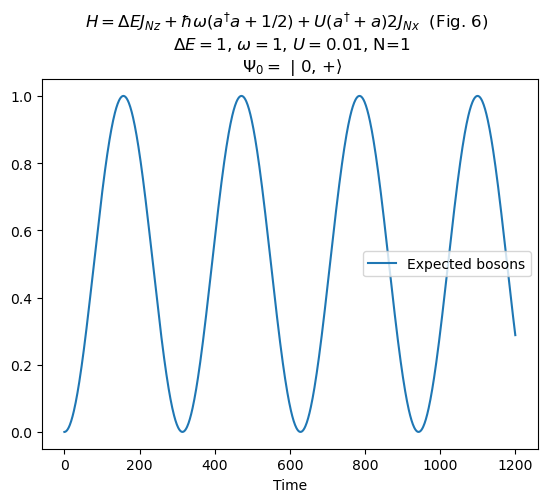

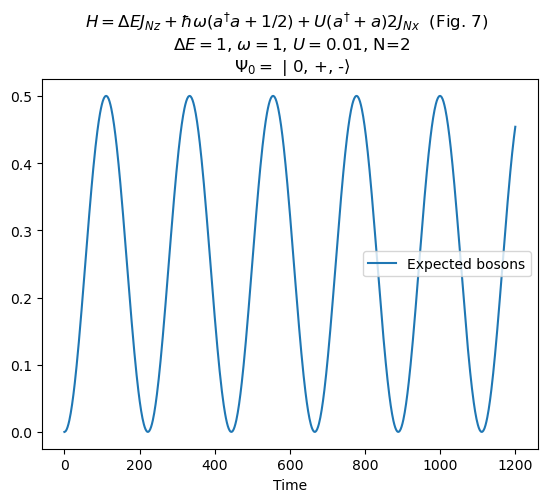

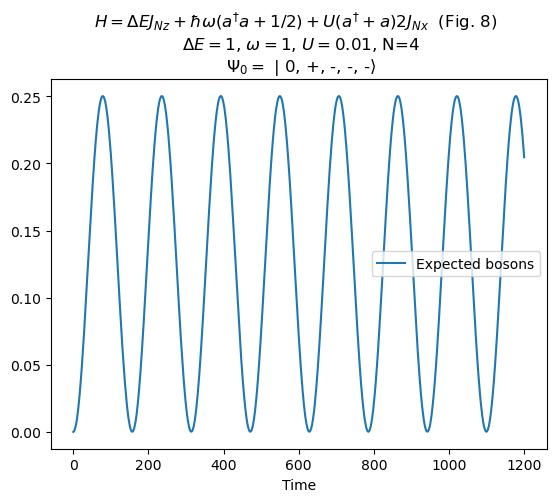

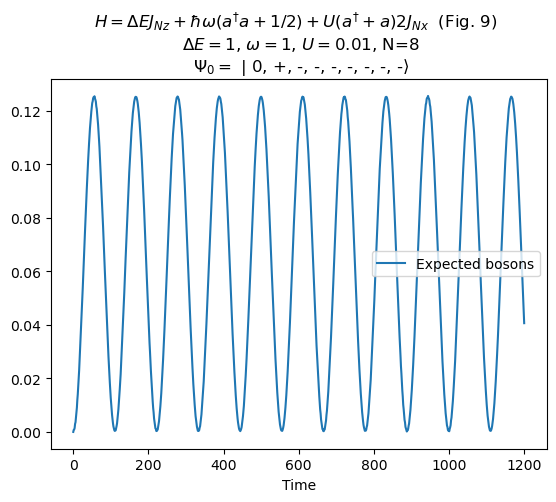

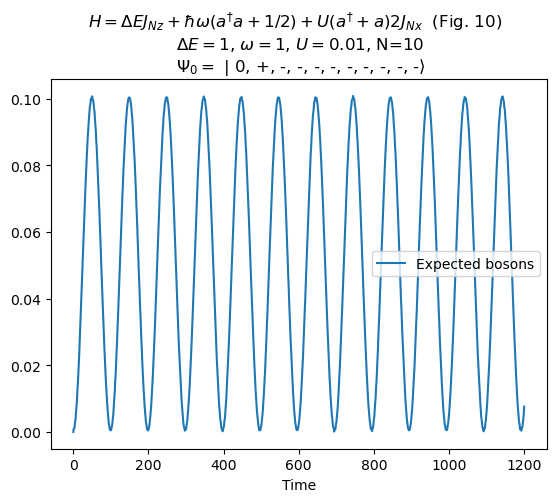

CPU times: user 2min 19s, sys: 5.75 s, total: 2min 24s
Wall time: 1min 50s


In [426]:
%%time 
# %%time must be at the top of the cell and by itself. It tells you the "Wall time" (how long the cell took to run) at the end of the output (should be about 2 min).

Ns = [1,2,4,8,10] # number of TLS we want to simulation
times = np.linspace(0.0, 1200.0, 1000) # simulation time
rabi = [] # For storing rabi frequency associated with excitation transfer

for i, N in enumerate(Ns):
    two_state, bosons, interaction, number, nm_list, J2 = make_operators(max_bosons=2, parity=-1, num_TLS=N)

    bra_labels, ket_labels = make_braket_labels(nm_list)
    
    H = DeltaE*two_state + omega*bosons + U*interaction

    psi0, psi0_ind = create_single_excitation_psi0(nm_list,0)

    # We are using custom simulate and expectation function from last tutorial. These are quicker than QuTips solvers for our specific purpose
    P, psi = simulate(H, psi0, times)
    bosons_expectation = expectation(number,psi)

    # find_peaks from SciPy helps us find peaks.
    # The peak_2 - peak_1 should give us the end of the first rabi cycle because we start with zero bosons
    peaks, _ = find_peaks(bosons_expectation, prominence=0.05)
    peak_times = times[peaks]
   
    rabi.append(2*np.pi / (peak_times[1] - peak_times[0]))
    # print((peak_times[1] - peak_times[0]))

    plt.plot(times, bosons_expectation, label="Expected bosons")
    plt.xlabel("Time")
    plt.legend(loc="right")
    plt.title(f"{H_latex} (Fig. {i+6})  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={N} \n $\Psi_0 =$ {ket_labels[psi0_ind]}")
    plt.show();

We see the same trends as with excitation transfer when we increase the number of TLS:
1. the frequency of the emission cycles increases
2. the amplitude of the emission cycles decreases

Let's see if we have the same scaling with $N$ for the Rabi frequency.



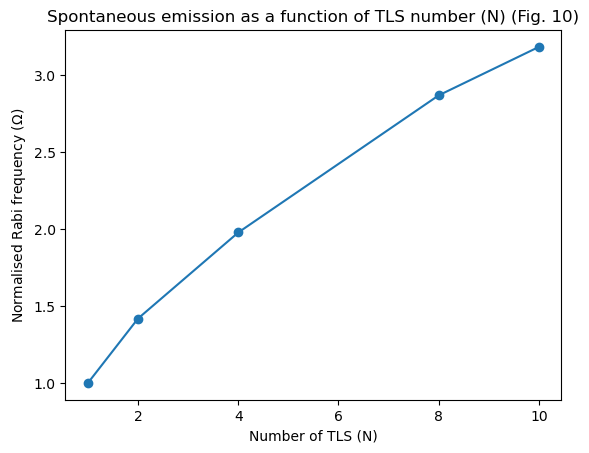

In [97]:
plt.plot(Ns,rabi/rabi[0],"-o")
plt.xlabel("Number of TLS (N)")
plt.ylabel("Normalised Rabi frequency ($\Omega$)");
plt.title("Spontaneous emission as a function of TLS number (N) (Fig. 10)");

Unlike excitation transfer, spontaneous emission appears to not benefit as much from increasing TLS number. We can see if the scaling is a power of $N$ by looking at the slope of $log_{10}(N)$ vs $log_{10}(\Omega)$:

In [108]:
print("slope = ", linregress(np.log10(Ns), np.log10(rabi)).slope)

slope =  0.5039884900865317


In [111]:
print("rvalue = ", linregress(np.log10(Ns), np.log10(rabi)).rvalue)

rvalue =  0.9998454164504081


The scaling of rabi frequency for spontaneous emission is an almost perfect fit to $\sqrt{N}$

For a moment, let's continue to suspend our concerns about incomplete Rabi oscillations and allow ourselves to speculate. The linear vs. sublinear enhancement of excitation transfer vs. spontaneous emission suggests that for a sufficiently large number of TLS excitation transfer could be the dominant process. For example, a long lived excited state might have opportunity to "hop" or "delocalise" to other TLS before decay eventually happens. Similar ideas have been discussed in the context of photosynthesis, where an excitation associated with an absorbed photon needs to find its way to a place where the energy can be useful before de-excitation happens and the energy is lost to the plant.

Let's not get too ahead of ourselves though. Before we can explore the competition between excitation transfer and spontaneous emission, we have a few more steps to take:
1. we need to understand why our Rabi oscillations are "incomplete".
2. we need to find a way to simulate more than 10 TLS without causing our computers to melt.

To tackle 1, we need to revisit our choice of initial state and see how it relates to the stationary states of the system.

## Crafting excited initial states

You may recall that if the system is in an eigenstate of the Hamiltonian, then it does not evolve in time - we say the system is in a stationary state.

If you're in a state that's a mixture of two stationary states, then the beating of the frequencies associated with the two energies causes the system to oscillate. That is the origin of Rabi oscillations that we explored right back in [tutorial 1](https://nbviewer.org/github/project-ida/two-state-quantum-systems/blob/master/01-an-isolated-two-state-system.ipynb).

Let's take a look at the stationary states for the $N=2$ spontaneous emission case and see whether they can provide some insight into our incomplete Rabi oscillation problem.

In [427]:
N = 2
DeltaE = 1
omega = 1

In [428]:
two_state, bosons, interaction, number, nm_list, J2 = make_operators(max_bosons=2, parity=-1, num_TLS=N)

In [429]:
H = DeltaE*two_state + omega*bosons + U*interaction

In [430]:
evals, ekets = H.eigenstates()

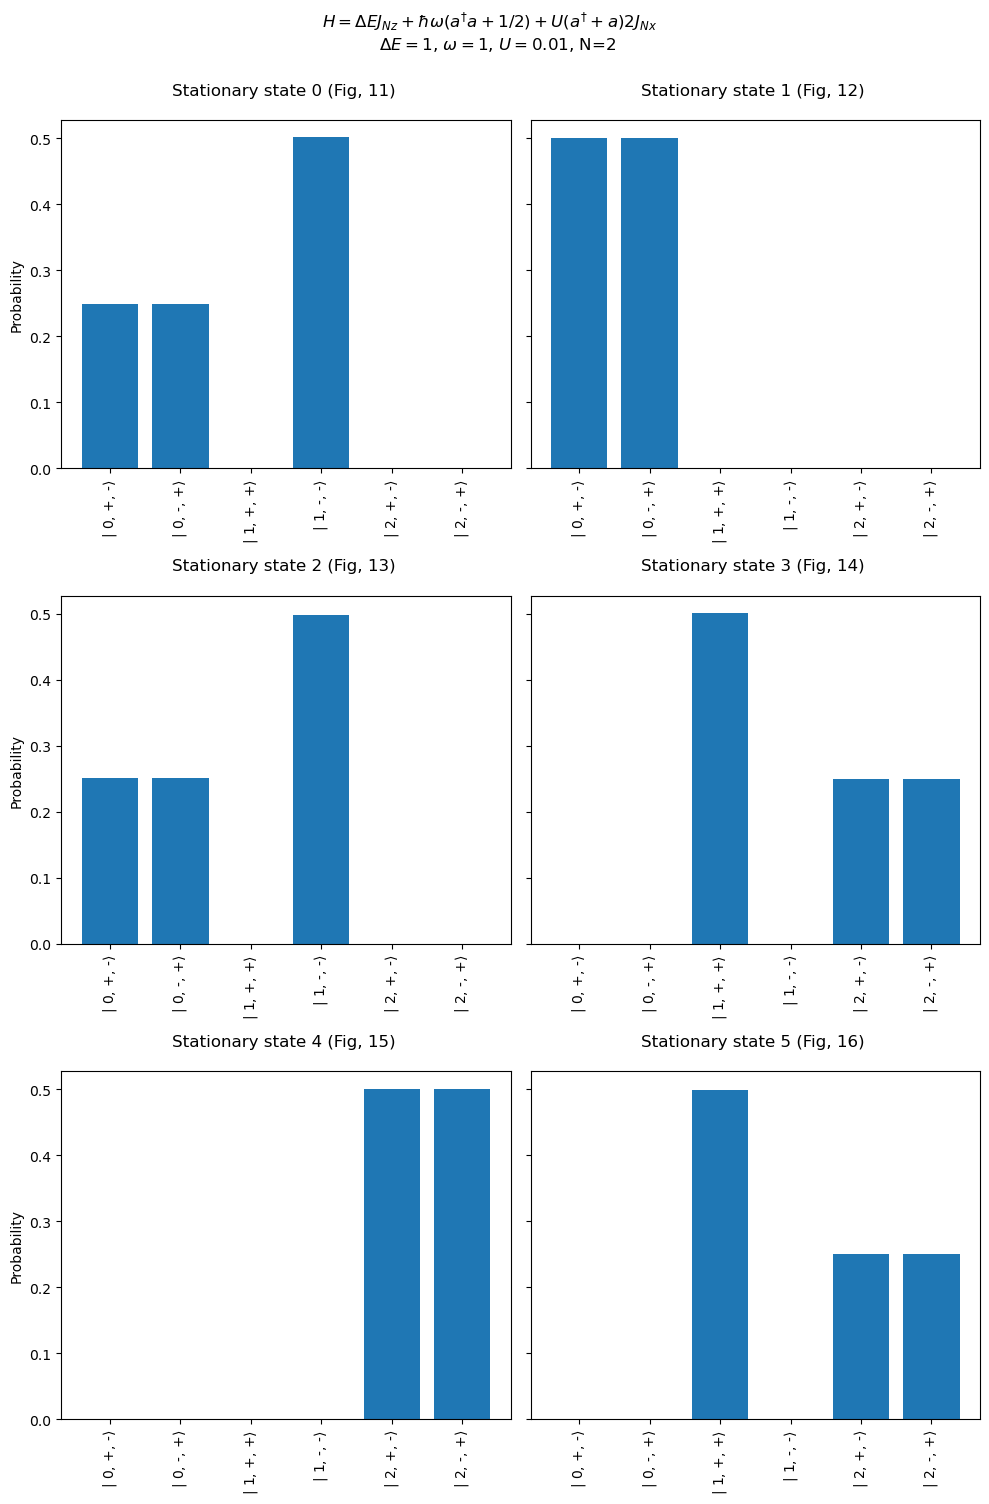

In [431]:
# Determine the layout of the subplot grid based on the number of eigenstates
n_states = len(ekets)
cols = 2
rows = int(np.ceil(n_states / cols))

fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 5*rows), sharey=True)
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Generate the state labels for the x axes
bra_labels, ket_labels = make_braket_labels(nm_list)


# Plot each eigenstate in a subplot
for i, ax in enumerate(axs):

    # Calculate the column index for the current plot
    col = i % cols
    
    # Calculate probabilities for the ith eigenstate
    probabilities = np.abs(ekets[i].full().flatten())**2
    
    # Plot the bar chart for this eigenstate
    ax.bar(ket_labels, probabilities)
    
    # Set the title for this subplot
    ax.set_title(f'Stationary state {i} (Fig, {11+i}) \n  ')

    # Set x-axis labels; rotate for readability if necessary
    ax.set_xticklabels(ket_labels, rotation=90)
    
    # Only add y-axis label on the leftmost subplots
    if col == 0:
        ax.set_ylabel('Probability')

fig.suptitle(f"{H_latex}  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={N}", y=1.00)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


Where do we put out focus in the above figures? 

In our simulations of spontaneous emission, we're interested in moving between 0 bosons and 1 boson. The stationary states, 0 and 2 (shown in Figs. 11 and 13) are therefore of interest to us because they appear to be composed of $| 0, +, -\rangle$, $| 0, -, +\rangle$ and $| 1, -, -\rangle$. Let's take a closer look at the associated states and energies.

First, stationary state 0:

In [404]:
evals[0]

0.48570743252867676

In [402]:
ekets[0]

Quantum object: dims = [[6], [1]], shape = (6, 1), type = ket
Qobj data =
[[-0.4991028 ]
 [-0.4991028 ]
 [ 0.00502594]
 [ 0.7083201 ]
 [-0.00500833]
 [-0.00500833]]

Now, stationary state 2:

In [405]:
evals[2]

0.5139925874690727

In [403]:
ekets[2]

Quantum object: dims = [[6], [1]], shape = (6, 1), type = ket
Qobj data =
[[ 0.50087065]
 [ 0.50087065]
 [-0.00497292]
 [ 0.70582055]
 [-0.00499066]
 [-0.00499066]]

In comparing stationary states 0 and 2 we see:
1. they have similar energies - ideal for the frequency beating associated with Rabi oscillations
2. the main components of the stationary states ($| 0, +, -\rangle$, $| 0, -, +\rangle$, $| 1, -, -\rangle$) are in combinations that are reminiscent of the symmetric and anti-symmetric combinations that we've seen before with Rabi oscillations (we also referred to them as "in phase" / "out of phase" combinations).

Digging into point 2 a little more, the stationary states 0 and 2 are approximately represented by:

$\Psi_{H_0}$ $\approx$ $0.7| 1, -, -\rangle -0.5 | 0, +, -\rangle - 0.5| 0, -, +\rangle $

$\Psi_{H_2}$ $\approx$ $0.7| 1, -, -\rangle + 0.5 | 0, +, -\rangle + 0.5| 0, -, +\rangle $

If we now recall how to think about symmetric and anti-symmetric combinations of states:
- $\Psi + \Phi$ - symmetric
- $\Psi - \Phi$ - anti-symmetric

then we are invited to consider setting up our system in the combination of states given by:

$\Psi_0 \sim | 0, +, -\rangle + | 0, -, +\rangle$

We can conceptually think of this as the system having 1 TLS excitation but we don't know which TLS is actually excited.

We might then hope the system will Rabi oscillation between $| 0, +, -\rangle + | 0, -, +\rangle$ and $| 1, -, -\rangle$. In other words, between 0 bosons and 1 boson.

Let's see if it works.

We need to find the right number states from which to create the combined initial state:

In [447]:
print(nm_list[0])
print(nm_list[1])

(0, '+', '-')
(0, '-', '+')


In [435]:
psi0 = basis(len(nm_list),0) + basis(len(nm_list),1) # creates combination of states
psi0 = psi0.unit() # make sure the initial state is normalised

In [436]:
P, psi = simulate(H, psi0, times)
bosons_expectation = expectation(number,psi)

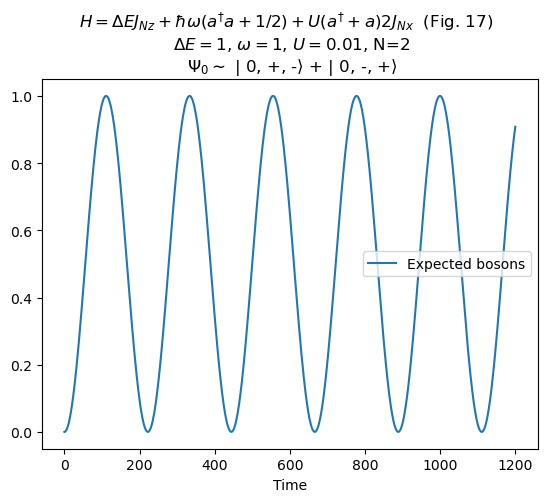

In [445]:
plt.plot(times, bosons_expectation, label="Expected bosons")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f"{H_latex} (Fig. 17)  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={N} \n $\Psi_0 \sim$ {ket_labels[0]} + {ket_labels[1]}")
plt.show();

Fig. 17 shows the same Rabi frequency that we saw in the spontaneous emission simulation in Fig 7 but now the oscillations are complete, i.e. they go from 0 to 1.

Let's see if we can perform the same trick for 4 TLS.

In [461]:
N = 4
DeltaE = 1
omega = 1

two_state, bosons, interaction, number, nm_list, J2 = make_operators(max_bosons=2, parity=-1, num_TLS=N)

H = DeltaE*two_state + omega*bosons + U*interaction

bra_labels, ket_labels = make_braket_labels(nm_list)

We can have a go at guessing the required initial state by creating a state in which 1 of the 4 TLS is excited but we don't know which one:

$\Psi_0 \sim | 0, +, -, -, - \rangle + | 0, -, +, -, - \rangle + | 0, -, -, +, - \rangle + | 0, -, -, -, + \rangle$

Finding the number states is a bit trickier this time (and gets harder as we increase $N$):

In [462]:
print(nm_list[3])
print(nm_list[5])
print(nm_list[6])
print(nm_list[7])

(0, '+', '-', '-', '-')
(0, '-', '+', '-', '-')
(0, '-', '-', '+', '-')
(0, '-', '-', '-', '+')


In [463]:
# creates combination of states
psi0 = basis(len(nm_list),3) + basis(len(nm_list),5) + basis(len(nm_list),6) + basis(len(nm_list),7) 

# make sure the initial state is normalised
psi0 = psi0.unit() 

In [464]:
P, psi = simulate(H, psi0, times)
bosons_expectation = expectation(number,psi)

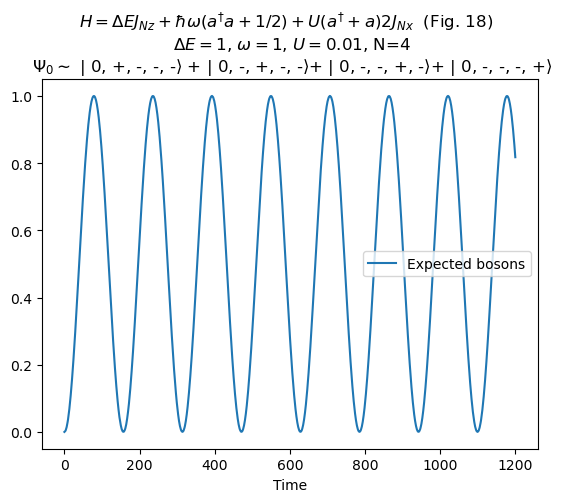

In [467]:
plt.plot(times, bosons_expectation, label="Expected bosons")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f"{H_latex} (Fig. 18)  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={N} \n $\Psi_0 \sim$ {ket_labels[3]} + {ket_labels[5]}+ {ket_labels[6]}+ {ket_labels[7]}")
plt.show();

Success! Fig. 18 shows the same Rabi frequency that we saw in the spontaneous emission simulation in Fig 8 and now the oscillations are complete.

### Entangled states

Our exploration of stationary states has revealed something important - the dynamics of many TLS depend not only on the number of TLS ($N$) but also on how those TLS are set-up. In particular, we appear to get an enhancement of some quantum processes when excitations are "shared" / "spread out" / "delocalised" over many TLS in such a way that we are not able to determine which TLS are actually excited. Such states are often said to be "entangled" states. 

Entanglement is in general a [complicated topic for more than two systems](https://arxiv.org/pdf/1305.2818.pdf) and we'll not do a deep dive on it here. For two systems, however, we can say simply that if knowledge of one gives you knowledge of the other then the systems are entangled. For example, in the state $| 0, +, -\rangle + | 0, -, +\rangle$ , if we perform a measurement and the first system is "+" then we know immediately the other is "-".